# Text mining 
## Lab 02 Basic word2vec example

We are going to train a Basic Word2Vec embeddings over Wikipedia using Skip-gram model [Mikolov at al.](https://arxiv.org/pdf/1301.3781.pdf) Section 3.2.

For this puprose we'll use Tensorflow, and sklearn. Your job is to fill in the missing code into the cells below.

You will find the steps you need to perform in the **Task** section in each cell.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow as tf

# Step 1: Download the data.

Download the Wikipeda data as a compressed zip file.

In [23]:
url = 'http://mattmahoney.net/dc/'


# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join(gettempdir(), filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename


filename = maybe_download('text8.zip', 31344016)


# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Found and verified text8.zip
Data size 17005207


# Step 2: Build the dictionary

The next step is to create a dictionary with words, and replace rare words with UNK token, to avoid heavy computations.

**Tasks:**

0.   Fill the method build_dataset;
1.   Use [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) to count the word numbers and to fill a dictionary with size vocabulary_size -> Word; Occurences.;
2.   Make 'UNK' to be the first token in your dictionary;
3.   Return data, count, dictionary, and reverse_dictionary as stated below.

**Expected: **

Filling 4 global variables:
1. data - list of codes (integers from 0 to vocabulary_size-1). This is the original text but words are replaced by their codes
2. count - map of words(strings) to count of occurrences
3. dictionary - map of words(strings) to their codes(integers)
4. reverse_dictionary - maps codes(integers) to words(strings)

Example of 10 words dictionary:

Most common words (+UNK) [['UNK', 12991886], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]

Sample data [0, 0, 0, 6, 0, 2, 0, 0, 0, 0] ['UNK', 'UNK', 'UNK', 'a', 'UNK', 'of', 'UNK', 'UNK', 'UNK', 'UNK']

1. dictionary: [['UNK', 12991886], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
2. reverse_dictionary: {0: 'UNK', 1: 'the', 2: 'of', 3: 'and', 4: 'one', 5: 'in', 6: 'a', 7: 'to', 8: 'zero', 9: 'nine'}


In [54]:
vocabulary_size = 50000


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""

  from collections import Counter
  c = Counter(vocabulary)
  most_common = c.most_common()
  
  i=1
  dictionary = dict()
  reversed_dictionary = dict()
  dictionary['UNK'] = 0
  reversed_dictionary[0] = 'UNK'
  unk_counts = 0
  for word, count in most_common:
    if i < n_words:
      dictionary[word] = i
      reversed_dictionary[i] = word
    else:
      unk_counts+=count
    i+=1
    
  count = [('UNK', unk_counts)] + most_common
  data = [dictionary.get(word, 0) for word in vocabulary]  
  
  return data, count, dictionary, reversed_dictionary

# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [('UNK', 418391), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


# Step 3: Function to generate a training batch for the skip-gram model.

Here is the logic for generating training batches. You don't have to modify it.

In [55]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer[:] = data[:span]
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


# Step 4: Build and train a skip-gram model.

Here we define the skip-gram model with Negative Sampling, as a graph. Graphs are lazy, hence you must construct a session object, init variables init.run() and after that .run()/.eval() rest of your operations. These steps are done for you in the next section 5.

**Tasks:**


1.   Init embeddings variable as a tf.Variable, and init it with $Unif(-1.0, 1.0)$ [random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform). The shape must be [vocabulary_size, embedding_size];
2.   Init nce_weights variable as a tf.Variable, and init it with  truncated normal with $\mathcal{N}(0.0, \frac{1}{embedding\_size})$ (second argument is var, so you need to transorm it to standrad deviation) [truncated_normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal), again with shape [vocabulary_size, embedding_size];
3.   Init the loss object as the mean of Noise-contrastive estimation function [nce_loss](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss) $J^{(t)}_\text{NEG} = \log Q_\theta(D=1 | \text{the, quick}) +
  \log(Q_\theta(D=0 | \text{sheep, quick}))$
4. Fill the similarity object as cos similarity (dot product), between valid_embeddings, and normalized_embeddings $cos(X, Y) =  \frac{X \cdot Y}{\|X\|\|Y\|}$.


In [0]:
embedding_size = 300
embeddings = tf.Variable(tf.random_uniform(
    [vocabulary_size, embedding_size], -1, 1))

In [0]:
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 10       # How many words to consider left and right.
num_skips = 4         # How many times to reuse an input to generate a label.
num_sampled = 128      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)


graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Set device to cpu or gpu depending on what you have.
  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform(
        [vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal(
        [vocabulary_size, embedding_size], 0, math.sqrt(1/embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  loss = tf.reduce_mean(tf.nn.nce_loss(
    nce_weights,
    nce_biases,
    train_labels,
    embed,
    num_sampled,
    vocabulary_size
))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings/norm #Use norm and embeddings
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

# Step 5: Begin training.

Basic traing with your graph built in step 4. Each 10k steps similarity examples of the current embeddings are outputed. Training error is outputed each 2k steps.

In [64]:
num_steps = 200001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  500.15838623046875
Nearest to seven: landslides, neko, wilfrid, lapsed, salinity, cosmologists, anonymous, jimmy,
Nearest to many: hemisphere, catarina, welcoming, textual, urge, hammersmith, side, tells,
Nearest to first: berkshire, siam, vary, widget, constructive, besieged, secreting, ethnocentrism,
Nearest to after: marcia, icsu, predominant, accountants, superintendent, fick, mathew, nightlife,
Nearest to had: attendances, gobind, ankobra, scully, mediocre, subjecting, infoplease, simplicius,
Nearest to often: basse, organizes, beverages, coffins, idiosyncratic, declarative, donnie, internals,
Nearest to been: scroll, donations, sabrina, dnow, shipper, sunga, ratings, spire,
Nearest to was: osu, nineteen, jagie, savior, lactamase, predictably, reproducing, wes,
Nearest to if: pence, musab, janitor, routledge, frisch, ozzfest, apostrophe, argento,
Nearest to this: ushered, slips, dozen, halloween, asuras, ricardo, pwn, extant,
Nearest to are: 

Average loss at step  46000 :  7.28232982134819
Average loss at step  48000 :  7.15020636177063
Average loss at step  50000 :  7.427647057533264
Nearest to seven: one, nine, five, eight, six, four, three, two,
Nearest to many: of, and, mathbf, gland, in, to, cl, from,
Nearest to first: gland, in, mathbf, s, a, backslash, cl, markov,
Nearest to after: his, was, rotate, in, victoriae, two, alps, gland,
Nearest to had: to, gland, mathbf, as, with, for, in, gb,
Nearest to often: victoriae, es, gunpowder, as, mathbf, stylization, hogeschool, by,
Nearest to been: and, backslash, mathbf, sunga, gland, with, dddddd, is,
Nearest to was: by, in, gland, his, mathbf, for, with, a,
Nearest to if: that, junctions, to, mathbf, it, rationalism, gland, thinkpad,
Nearest to this: to, that, gland, for, by, a, with, in,
Nearest to are: as, for, is, and, mathbf, gland, of, with,
Nearest to while: coke, gimme, UNK, gland, gb, cl, in, backslash,
Nearest to eight: one, five, seven, nine, four, six, three, two

Average loss at step  100000 :  5.948044310331345
Nearest to seven: eight, six, three, gland, four, mathbf, five, nine,
Nearest to many: are, mathbf, gland, of, and, or, in, markov,
Nearest to first: in, gland, by, s, was, mathbf, with, which,
Nearest to after: he, was, with, his, s, mathbf, gland, rotate,
Nearest to had: was, gland, mathbf, his, s, he, by, to,
Nearest to often: victoriae, are, as, for, mathbf, also, stylization, hogeschool,
Nearest to been: the, have, by, with, gland, that, it, mathbf,
Nearest to was: by, gland, he, in, and, his, s, an,
Nearest to if: that, be, the, mathbf, junctions, not, a, it,
Nearest to this: that, gland, it, an, which, mathbf, is, with,
Nearest to are: or, which, mathbf, gland, is, and, have, the,
Nearest to while: and, gland, a, coke, gb, or, cl, backslash,
Nearest to eight: seven, six, nine, five, three, four, one, gland,
Nearest to th: eight, gland, one, seven, zero, three, five, mathbf,
Nearest to UNK: and, gland, mathbf, with, by, the, of, s

Average loss at step  150000 :  5.825926704406738
Nearest to seven: six, eight, five, four, nine, three, one, two,
Nearest to many: some, microsite, have, mathbf, other, gland, are, most,
Nearest to first: was, gland, by, s, microsite, in, of, thibetanus,
Nearest to after: was, he, his, had, were, gland, but, mathbf,
Nearest to had: was, his, he, were, but, have, gland, to,
Nearest to often: victoriae, they, which, but, gland, microcebus, also, most,
Nearest to been: have, has, some, but, gland, were, microsite, thibetanus,
Nearest to was: his, had, he, first, s, were, by, gland,
Nearest to if: that, be, it, not, to, a, but, or,
Nearest to this: which, it, gland, an, a, that, or, thibetanus,
Nearest to are: or, other, some, which, is, gland, have, thibetanus,
Nearest to while: which, gland, that, coke, with, gb, but, this,
Nearest to eight: five, six, seven, nine, four, one, three, two,
Nearest to th: eight, one, gland, of, five, nine, thibetanus, two,
Nearest to UNK: gland, and, thibe

Average loss at step  200000 :  5.727593496680259
Nearest to seven: five, one, three, four, nine, six, eight, zero,
Nearest to many: some, most, these, other, have, and, all, iit,
Nearest to first: was, s, gland, iit, by, microsite, the, in,
Nearest to after: he, was, had, his, when, with, gland, were,
Nearest to had: was, he, his, were, has, after, but, have,
Nearest to often: as, is, most, gland, or, victoriae, many, also,
Nearest to been: has, have, many, were, it, some, but, its,
Nearest to was: he, first, had, s, his, by, but, it,
Nearest to if: this, that, not, a, is, to, be, but,
Nearest to this: an, gland, the, a, which, it, thibetanus, is,
Nearest to are: other, some, these, such, or, many, is, can,
Nearest to while: gland, backslash, iit, in, thibetanus, microsite, some, but,
Nearest to eight: one, seven, four, six, three, two, five, nine,
Nearest to th: six, nine, two, gland, three, first, seven, in,
Nearest to UNK: gland, iit, and, s, mathbf, thibetanus, microsite, one,
Nea

# Step 6: Basic operations with embeddings

Some basic examples of the power of Word2Vec model.
1. Finding the most similar words by a single word query.
2. Showing the famous example of  the  analogy  “king  is  to queen  as  man  is  to  woman”. This should  be  encoded in the vector space by the vector equation $king − man = queen − woman$

In [65]:
def cos_sim(a, b):
    from numpy import dot
    from numpy.linalg import norm

    return dot(a, b)/(norm(a)*norm(b))

def similar_to_vec(word, top_k = 8):
  sim = cos_sim(final_embeddings, word)
  return (-sim[:]).argsort()[1:top_k + 1]


def find_similar(valid_word):
  word = final_embeddings[dictionary[valid_word]]

  top_k = 8  # number of nearest neighbors
  nearest = similar_to_vec(word)
  
  log_str = 'Nearest to %s:' % valid_word
  for k in xrange(top_k):
    close_word = reverse_dictionary[nearest[k]]
    log_str = '%s %s,' % (log_str, close_word)

  print(log_str)
    
find_similar('seven') 

Nearest to seven: five, one, three, four, nine, six, eight, zero,


In [66]:
king = final_embeddings[dictionary['king']]
queen = final_embeddings[dictionary['queen']]
man = final_embeddings[dictionary['man']]
woman = final_embeddings[dictionary['woman']]

print(cos_sim(king, queen))
print(cos_sim(man, woman))
print(cos_sim(king - man, queen - woman))

0.2027233
0.26338056
0.08020065


# Step 7: Visualize the embeddings.

Comparision between t-SNE and PCA.

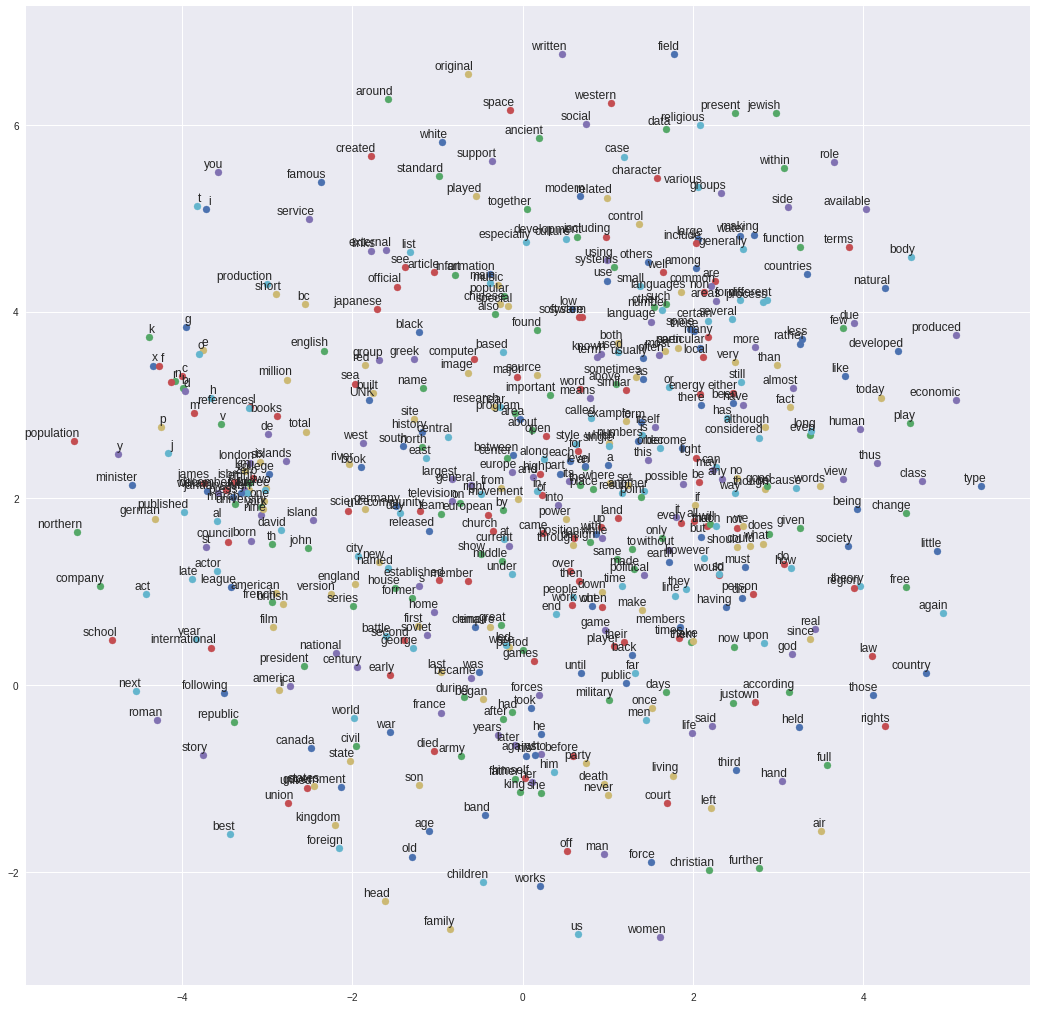

In [67]:
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

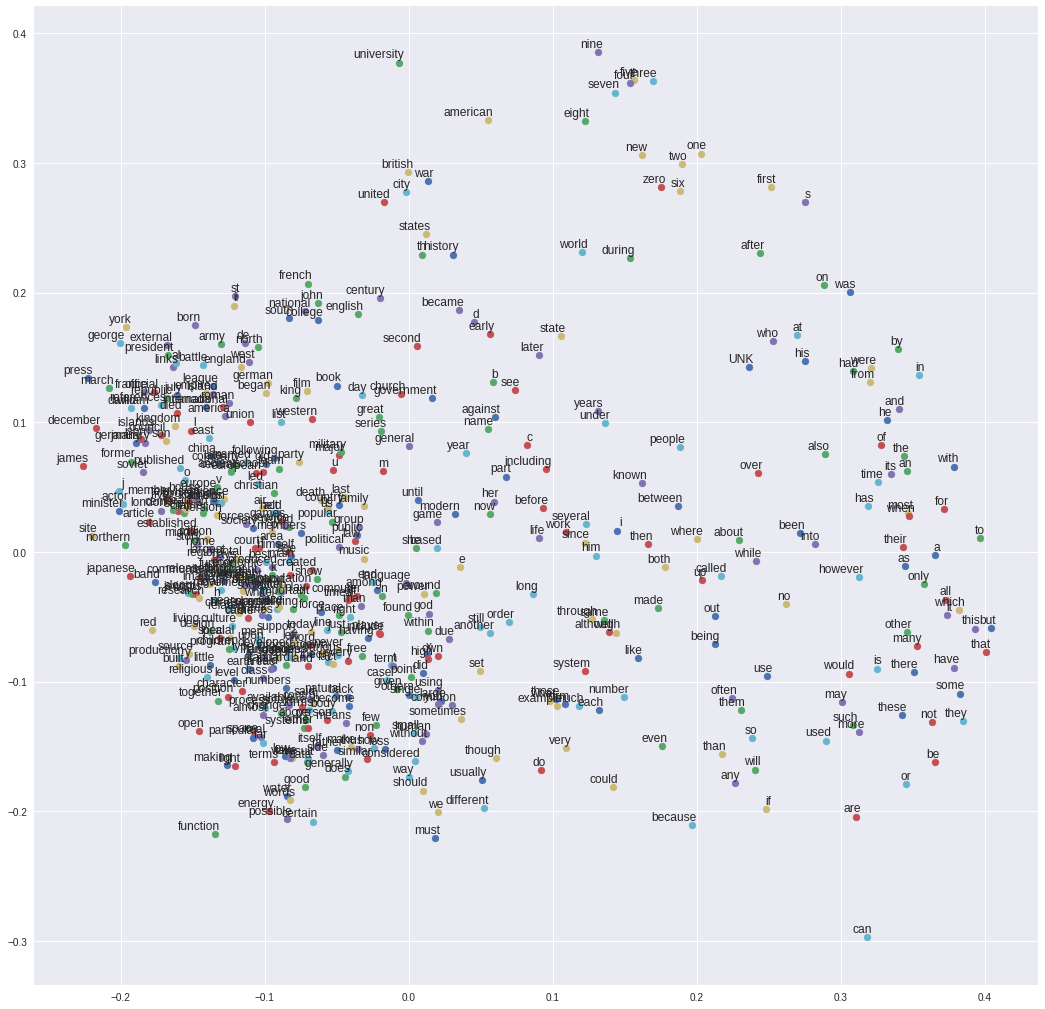

In [68]:
try:
  from sklearn.decomposition import PCA
  import matplotlib.pyplot as plt

  pca = PCA(n_components=2)
  plot_only = 500
  
  low_dim_embs = pca.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'pca.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

# Homework

## Tasks 
Compare the results after performing each of those steps:

1.   Visualize your embeddings using TensorBoard and this [tutorial](https://www.tensorflow.org/programmers_guide/embedding#visualizing_embeddings).
2.   Compare results from vectors fitted with LSA (Train SVD on term-document matrix or co-occurences matrix, to produce $U \Sigma V^T$ and use the first K-dimentions of the latent vectors from U to represent words) to Word2Vec. The SVD methods can be found [here](https://cs224d.stanford.edu/lecture_notes/notes1.pdf).